In [ ]:
# Install necessary libraries
#!pip install geemap earthengine-api

In [ ]:
import ee
import geemap
import datetime
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='practical-well-464510-b1')

In [ ]:
aoi = ee.Geometry.Point([72.6144, 27.0238]) #72.6144, 27.0238

In [ ]:
# Load MODIS NDVI dataset
dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
            .filterBounds(aoi) \
            .filterDate('2021-01-01', '2021-12-31') \
            .select('NDVI')

In [ ]:
def extract_ndvi_time_series(aoi, dataset):
    def reduce_region(img):
        stats = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=500
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            'NDVI': stats.get('NDVI')
        })

    ndvi_features = dataset.map(reduce_region).filter(ee.Filter.notNull(['NDVI']))

    # Fetch data from Earth Engine as dictionary
    try:
        features = ndvi_features.getInfo()['features']
    except Exception as e:
        print("❌ Could not retrieve NDVI features:", e)
        return pd.DataFrame()  # return empty DataFrame to prevent crash

    # Extract date and NDVI
    records = []
    for f in features:
        props = f['properties']
        records.append({
            'date': props['date'],
            'NDVI': float(props['NDVI']) if props['NDVI'] is not None else None
        })

    return pd.DataFrame(records)


In [ ]:
ndvi_df = extract_ndvi_time_series(aoi, dataset)


In [ ]:
ndvi_df.head()

,date,NDVI
0,2021-01-01,3341.0
1,2021-01-09,3341.0
2,2021-01-17,4195.0
3,2021-01-25,4195.0
4,2021-02-02,4612.0


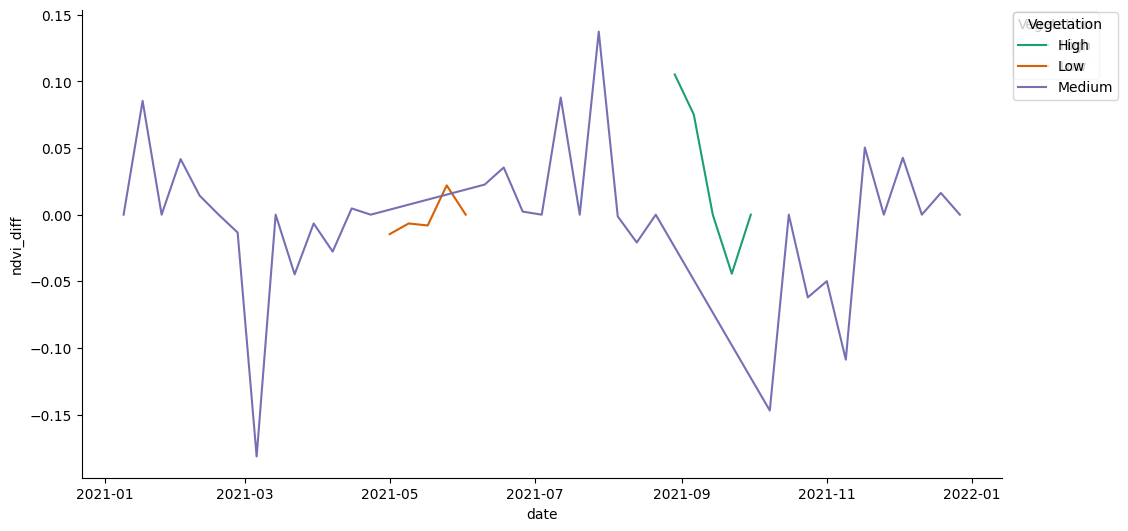

In [ ]:
# @title date vs ndvi_diff

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['ndvi_diff']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ndvi_df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Vegetation')):
  _plot_series(series, series_name, i)
  fig.legend(title='Vegetation', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('ndvi_diff')

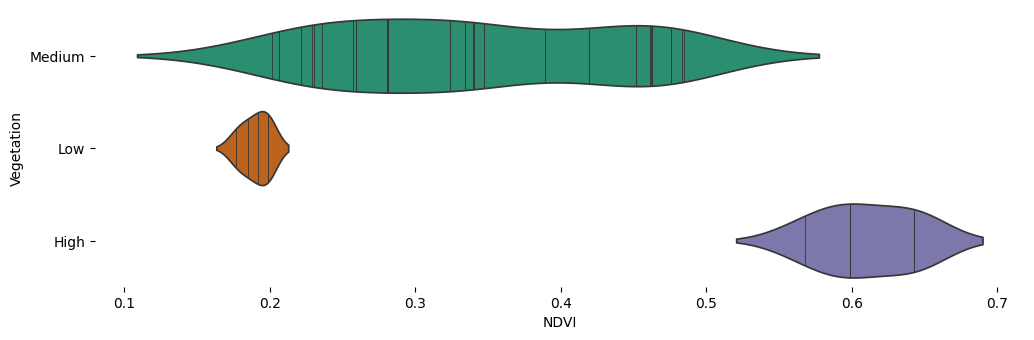

In [ ]:
# @title Vegetation vs NDVI

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(ndvi_df['Vegetation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(ndvi_df, x='NDVI', y='Vegetation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

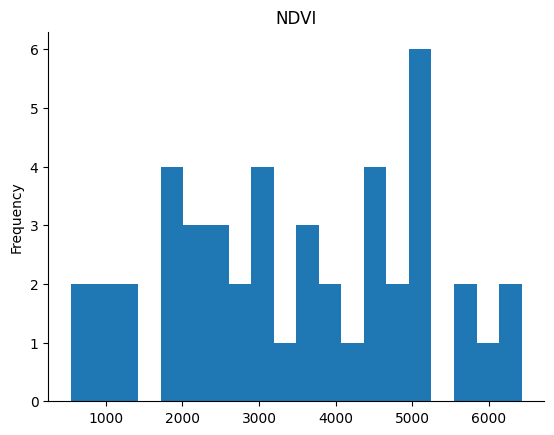

In [ ]:
# @title NDVI

from matplotlib import pyplot as plt
ndvi_df['NDVI'].plot(kind='hist', bins=20, title='NDVI')
plt.gca().spines[['top', 'right',]].set_visible(False)

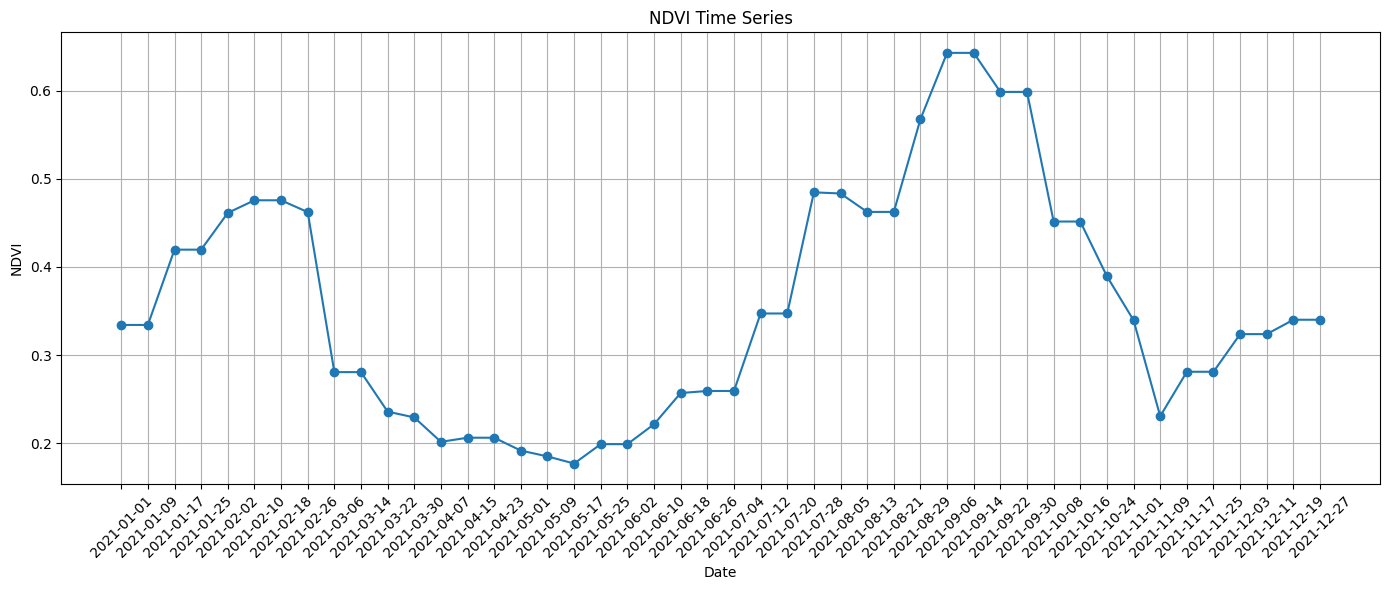

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(ndvi_df['date'], ndvi_df['NDVI'].astype(float) * 0.0001, marker='o')
plt.title('NDVI Time Series')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Pick a specific date image
ndvi_img = dataset.filterDate('2021-01-25', '2021-01-26').first()

Map = geemap.Map(center=[-26.2041, 28.0473], zoom=8)
Map.addLayer(ndvi_img, {'min': 0, 'max': 9000, 'palette': ['white', 'green']}, 'NDVI')
Map

Map(center=[-26.2041, 28.0473], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

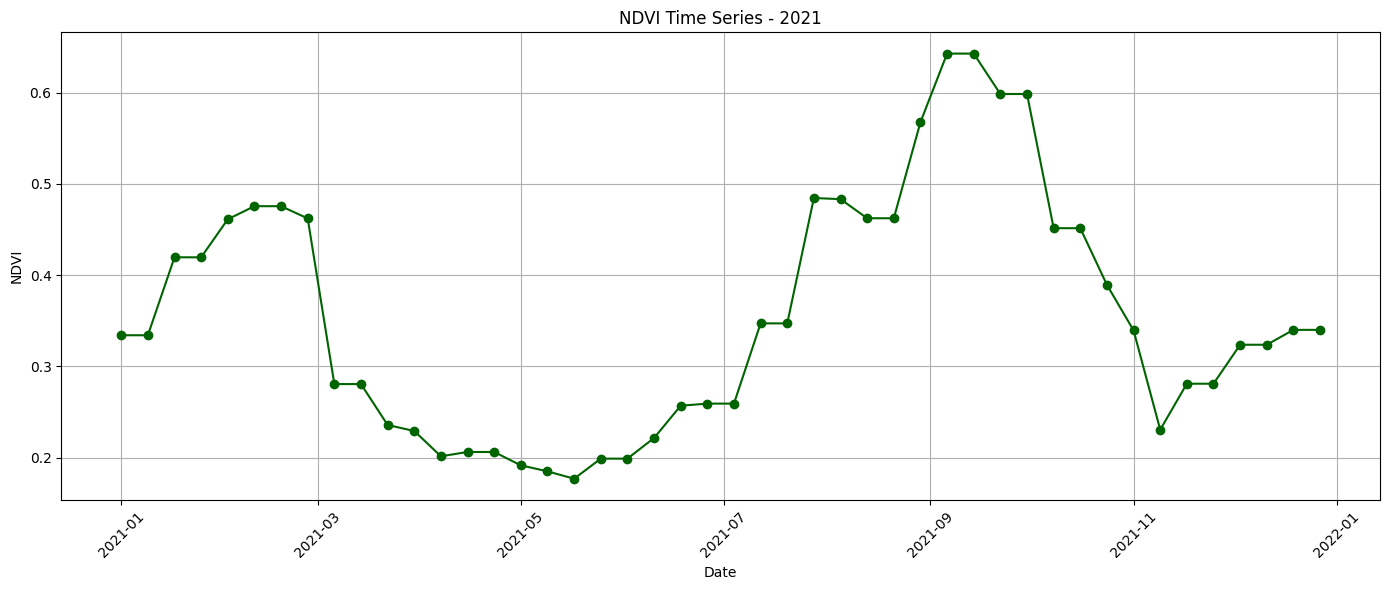

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(pd.to_datetime(ndvi_df['date']), ndvi_df['NDVI'].astype(float) * 0.0001, marker='o', color='darkgreen')
plt.title('NDVI Time Series - 2021')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("ndvi_timeseries.png", dpi=300)
plt.show()

In [ ]:
ndvi_df.to_csv("ndvi_timeseries_2021.csv", index=False)


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 114.0 MB/s eta 0:00:00


In [ ]:
ndvi_df['NDVI'] = ndvi_df['NDVI'].astype(float) * 0.0001
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

max_ndvi = ndvi_df.loc[ndvi_df['NDVI'].idxmax()]
min_ndvi = ndvi_df.loc[ndvi_df['NDVI'].idxmin()]

print("🌿 Max NDVI:", max_ndvi)
print("🍂 Min NDVI:", min_ndvi)

🌿 Max NDVI: date    2021-09-06 00:00:00
NDVI                 0.6427
Name: 31, dtype: object
🍂 Min NDVI: date    2021-05-17 00:00:00
NDVI                 0.1769
Name: 17, dtype: object


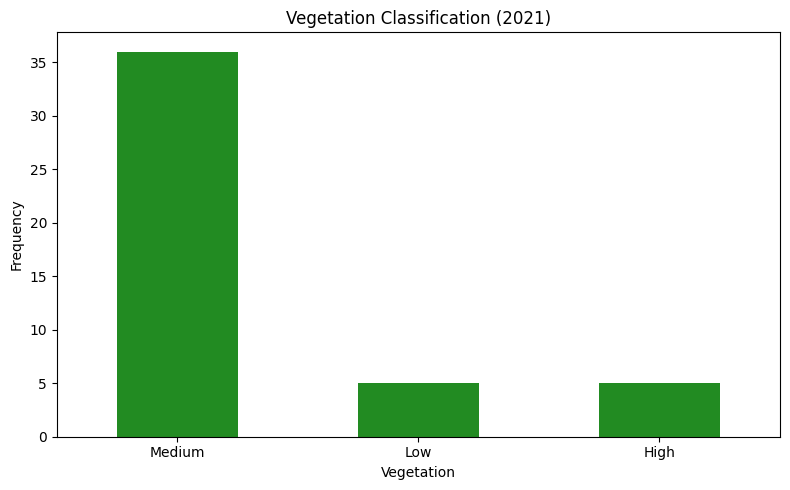

In [ ]:
def classify_ndvi(ndvi):
    if ndvi < 0.2:
        return 'Low'
    elif ndvi < 0.5:
        return 'Medium'
    else:
        return 'High'

ndvi_df['Vegetation'] = ndvi_df['NDVI'].apply(classify_ndvi)

# Plot counts
plt.figure(figsize=(8, 5))
ndvi_df['Vegetation'].value_counts().plot(kind='bar', color='forestgreen')
plt.title('Vegetation Classification (2021)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("ndvi_classification_bar.png", dpi=300)
plt.show()

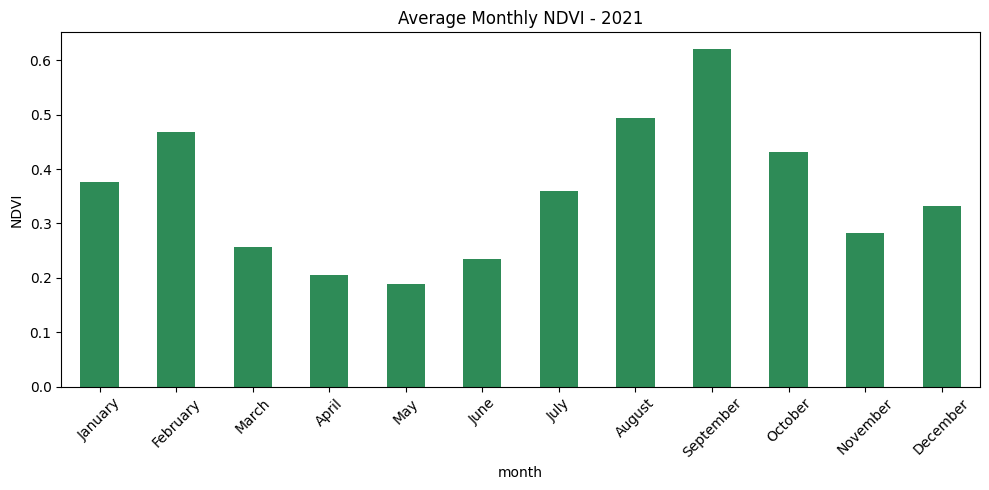

In [ ]:
ndvi_df['month'] = ndvi_df['date'].dt.month_name()

monthly_ndvi = ndvi_df.groupby('month', sort=False)['NDVI'].mean()

plt.figure(figsize=(10, 5))
monthly_ndvi.plot(kind='bar', color='seagreen')
plt.title('Average Monthly NDVI - 2021')
plt.ylabel('NDVI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ndvi_monthly_avg.png", dpi=300)
plt.show()


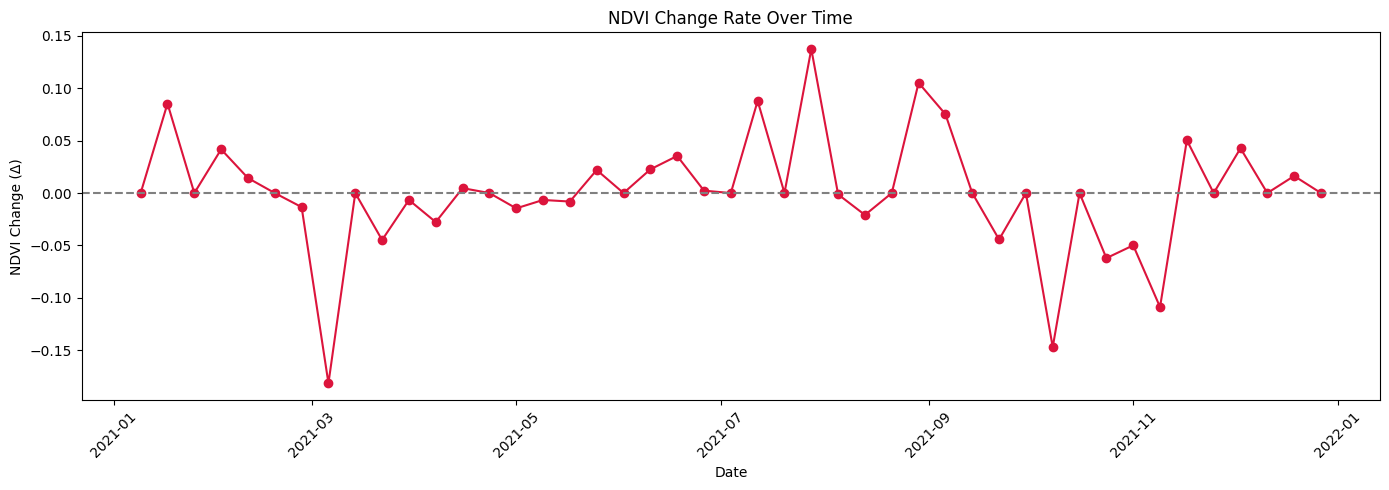

In [ ]:
ndvi_df['ndvi_diff'] = ndvi_df['NDVI'].diff()

plt.figure(figsize=(14, 5))
plt.plot(ndvi_df['date'], ndvi_df['ndvi_diff'], marker='o', color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("NDVI Change Rate Over Time")
plt.xlabel("Date")
plt.ylabel("NDVI Change (Δ)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ndvi_change_rate.png", dpi=300)
plt.show()


In [ ]:
import os
from PIL import Image
import geemap

os.makedirs("ndvi_png_frames", exist_ok=True)

# Get list of dates from the dataset
dates = dataset.aggregate_array('system:time_start').getInfo()

for d in dates:
    date = ee.Date(d).format('YYYY-MM-dd').getInfo()
    img = dataset.filterDate(date, ee.Date(date).advance(1, 'day')).first()

    vis_params = {'min': 0, 'max': 9000, 'palette': ['white', 'green']}
    out_file = f'ndvi_png_frames/ndvi_{date}.png'

    try:
        # 👇 FIXED: Removed keyword 'image='
        geemap.ee_export_image(
            img.visualize(**vis_params),    # image (1st positional argument)
            out_file,                       # filename
            aoi.buffer(5000),               # region
            500                             # scale
        )
        print(f"✅ Exported: {out_file}")
    except Exception as e:
        print(f"⚠️ Failed: {e}")


The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-01-01.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-01-09.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-01-17.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-01-25.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-02-02.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-02-10.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-02-18.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-02-26.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-03-06.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-03-14.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-03-22.png
The filename must end with .tif
✅ Exported: ndvi_png_frames/ndvi_2021-03-30.png
The filename must end with .tif
✅ Export

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='practical-well-464510-b1')

# Define a larger AOI
aoi = ee.Geometry.Point([72.6144, 27.0238]).buffer(20000)  # 20 km buffer

# Cloud masking using SCL band (Scene Classification Layer)
def maskS2clouds_SCL(image):
    scl = image.select('SCL')
    # Mask: cloud = 3, 8, 9, 10, 11; snow = 12
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11)).And(scl.neq(12))
    return image.updateMask(mask).divide(10000)

# Load Sentinel-2 SR images, apply cloud mask, select RGB bands
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterDate('2021-07-01', '2021-09-30')
    .filterBounds(aoi)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(maskS2clouds_SCL)
    .select(['B4', 'B3', 'B2'])  # Red, Green, Blue
)

# Confirm image count
count = collection.size().getInfo()
print(f"🛰️ Number of cloud-free images found: {count}")

if count == 0:
    print("❌ No images found. Try expanding the AOI or changing dates.")
else:
    video_args = {
        'region': aoi,
        'dimensions': 720,
        'framesPerSecond': 2,
        'bands': ['B4', 'B3', 'B2'],
        'min': 0.0,
        'max': 0.3
    }

    gif_path = 'sentinel2_timelapse.gif'

    # Export and display timelapse GIF
    geemap.download_ee_video(collection, video_args, gif_path)
    geemap.show_image(gif_path)


🛰️ Number of cloud-free images found: 32
Generating URL...
Please wait ...
The GIF image has been saved to: /content/sentinel2_timelapse.gif


Output()

In [ ]:
import pandas as pd

# Ensure proper types
ndvi_df['NDVI'] = ndvi_df['NDVI'].astype(float)
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df['month'] = ndvi_df['date'].dt.month
ndvi_df['month_name'] = ndvi_df['date'].dt.strftime('%B')

# 📈 Monthly Average NDVI
monthly_ndvi = ndvi_df.groupby('month_name')['NDVI'].mean().reset_index()
monthly_ndvi['NDVI'] = monthly_ndvi['NDVI'].round(4)

# ✅ Greenest month
greenest_month = monthly_ndvi.loc[monthly_ndvi['NDVI'].idxmax()]
print(f"✅ Greenest Month of 2021: {greenest_month['month_name']} (Avg NDVI: {greenest_month['NDVI']})")

# 🔥 Summer stress (April - June)
summer_months = ndvi_df[ndvi_df['month'].isin([4, 5, 6])]
avg_summer_ndvi = summer_months['NDVI'].mean().round(4)
print(f"🔥 Avg NDVI during early summer (Apr–Jun): {avg_summer_ndvi}")


✅ Greenest Month of 2021: September (Avg NDVI: 0.6206)
🔥 Avg NDVI during early summer (Apr–Jun): 0.2093


In [ ]:
# 🌧️ Post-monsoon increase: Compare July vs Sept
july_ndvi = ndvi_df[ndvi_df['month'] == 7]['NDVI'].mean().round(4)
sept_ndvi = ndvi_df[ndvi_df['month'] == 9]['NDVI'].mean().round(4)
diff = round(sept_ndvi - july_ndvi, 4)

if diff > 0:
    print(f"🌧️ NDVI increased by {diff} from July to September (Post-monsoon vegetation recovery).")
else:
    print(f"⚠️ NDVI decreased by {abs(diff)} from July to September.")

🌧️ NDVI increased by 0.2611 from July to September (Post-monsoon vegetation recovery).


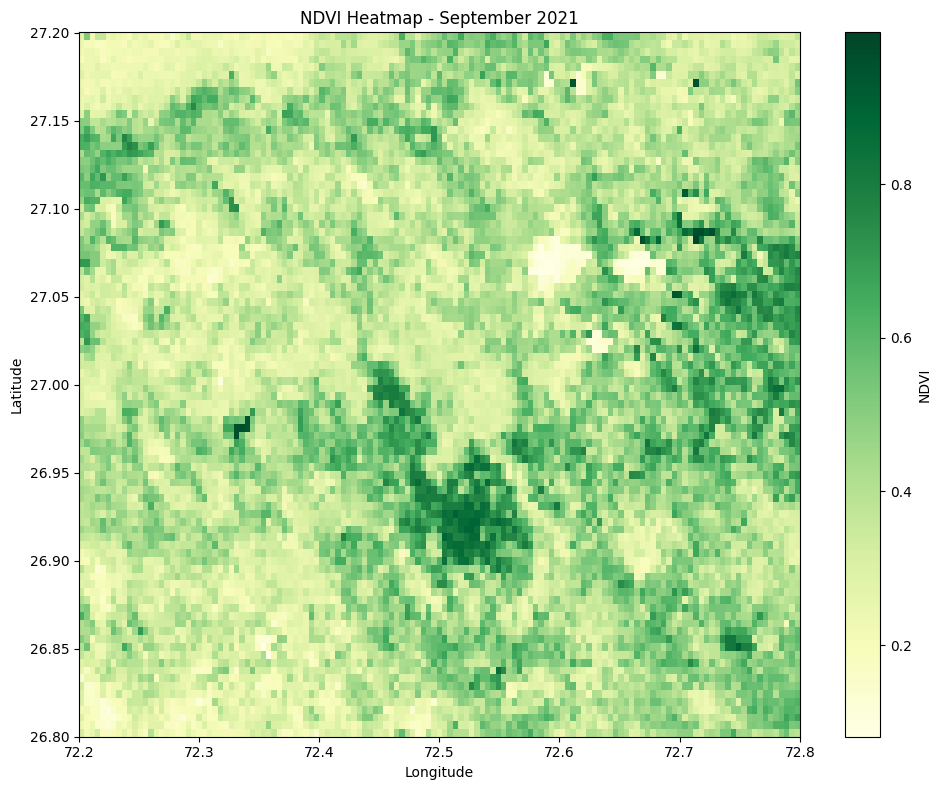

In [ ]:
# 📍 Define AOI (rectangle in Rajasthan)
aoi = ee.Geometry.Rectangle([72.2, 26.8, 72.8, 27.2])  # long1, lat1, long2, lat2

# 📅 Get one NDVI image (e.g., from 2021-09-01)
image = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
    .filterBounds(aoi) \
    .filterDate('2021-09-01', '2021-09-15') \
    .select('NDVI') \
    .median()

# 🔽 Download image as numpy array
ndvi_array = geemap.ee_to_numpy(image, region=aoi, scale=500)

# 🌍 Get lat/lon
lat = np.linspace(aoi.bounds().coordinates().getInfo()[0][0][1],
                  aoi.bounds().coordinates().getInfo()[0][2][1], ndvi_array.shape[0])
lon = np.linspace(aoi.bounds().coordinates().getInfo()[0][0][0],
                  aoi.bounds().coordinates().getInfo()[0][2][0], ndvi_array.shape[1])

# 🧹 Mask invalid data
ndvi_array = ndvi_array.astype(np.float32) * 0.0001
ndvi_array[ndvi_array <= 0] = np.nan  # mask water/no data

# 🎨 Plot NDVI heatmap
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_array, extent=(lon.min(), lon.max(), lat.min(), lat.max()),
           cmap='YlGn', origin='lower', aspect='auto')
plt.colorbar(label='NDVI')
plt.title('NDVI Heatmap - September 2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.tight_layout()
plt.savefig("ndvi_heatmap_sep2021.png", dpi=300)
plt.show()

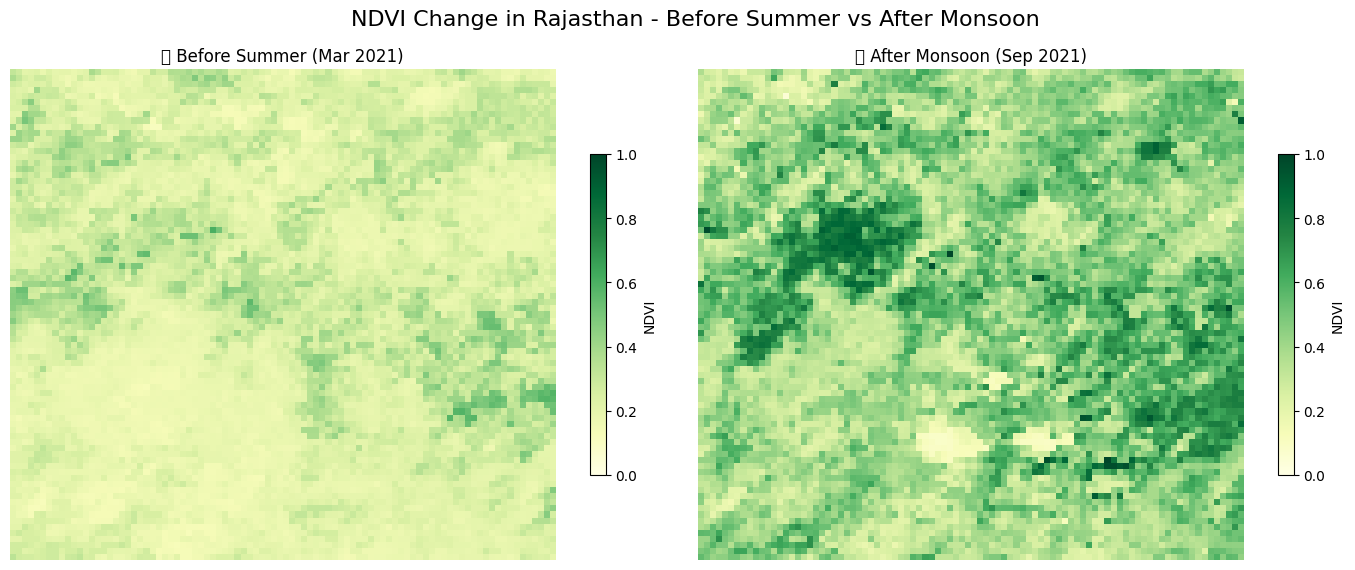

In [ ]:
# Define an AOI in Rajasthan (20 km buffer around a point)
aoi = ee.Geometry.Point([72.6144, 27.0238]).buffer(20000)

# Load VIIRS NDVI dataset
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
    .filterBounds(aoi) \
    .select('NDVI')

# Choose dates for before summer and after monsoon
before_summer = viirs.filterDate('2021-03-01', '2021-03-10').median()
after_monsoon = viirs.filterDate('2021-09-01', '2021-09-10').median()

# Convert to NumPy arrays
ndvi_before = geemap.ee_to_numpy(before_summer.clip(aoi), bands=['NDVI'], region=aoi, scale=500).squeeze() * 0.0001
ndvi_after = geemap.ee_to_numpy(after_monsoon.clip(aoi), bands=['NDVI'], region=aoi, scale=500).squeeze() * 0.0001

# Plot side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(ndvi_before, cmap='YlGn', vmin=0, vmax=1)
plt.title("🌞 Before Summer (Mar 2021)")
plt.axis('off')
plt.colorbar(label="NDVI", shrink=0.6)

plt.subplot(1, 2, 2)
plt.imshow(ndvi_after, cmap='YlGn', vmin=0, vmax=1)
plt.title("🌧️ After Monsoon (Sep 2021)")
plt.axis('off')
plt.colorbar(label="NDVI", shrink=0.6)

plt.suptitle("NDVI Change in Rajasthan - Before Summer vs After Monsoon", fontsize=16)
plt.tight_layout()
plt.savefig("ndvi_seasonal_comparison.png", dpi=300)
plt.show()

In [ ]:
aoi = ee.Geometry.Point([72.6144, 27.0238]).buffer(20000)

In [ ]:
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
    .filterBounds(aoi) \
    .filterDate('2021-03-01', '2021-09-30') \
    .select('NDVI')

In [ ]:
import os
import geemap
import matplotlib.pyplot as plt
import numpy as np

os.makedirs("ndvi_gif_frames", exist_ok=True)

dates = viirs.aggregate_array('system:time_start').getInfo()

for d in dates:
    date = ee.Date(d).format('YYYY-MM-dd').getInfo()
    img = viirs.filterDate(date, ee.Date(date).advance(1, 'day')).median()

    # Convert to NumPy array
    try:
        ndvi = geemap.ee_to_numpy(img.clip(aoi), bands=['NDVI'], region=aoi, scale=500).squeeze() * 0.0001

        if np.isnan(ndvi).all():
            continue  # Skip empty

        plt.figure(figsize=(6, 6))
        plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
        plt.title(f"NDVI on {date}")
        plt.axis('off')
        plt.colorbar(label="NDVI", shrink=0.6)
        plt.tight_layout()
        plt.savefig(f"ndvi_gif_frames/ndvi_{date}.png", dpi=150)
        plt.close()
        print(f"✅ Saved: ndvi_{date}.png")
    except Exception as e:
        print(f"⚠️ Skipped {date}: {e}")


✅ Saved: ndvi_2021-03-06.png
✅ Saved: ndvi_2021-03-14.png
✅ Saved: ndvi_2021-03-22.png
✅ Saved: ndvi_2021-03-30.png
✅ Saved: ndvi_2021-04-07.png
✅ Saved: ndvi_2021-04-15.png
✅ Saved: ndvi_2021-04-23.png
✅ Saved: ndvi_2021-05-01.png
✅ Saved: ndvi_2021-05-09.png
✅ Saved: ndvi_2021-05-17.png
✅ Saved: ndvi_2021-05-25.png
✅ Saved: ndvi_2021-06-02.png
✅ Saved: ndvi_2021-06-10.png
✅ Saved: ndvi_2021-06-18.png
✅ Saved: ndvi_2021-06-26.png
✅ Saved: ndvi_2021-07-04.png
✅ Saved: ndvi_2021-07-12.png
✅ Saved: ndvi_2021-07-20.png
✅ Saved: ndvi_2021-07-28.png
✅ Saved: ndvi_2021-08-05.png
✅ Saved: ndvi_2021-08-13.png
✅ Saved: ndvi_2021-08-21.png
✅ Saved: ndvi_2021-08-29.png
✅ Saved: ndvi_2021-09-06.png
✅ Saved: ndvi_2021-09-14.png
✅ Saved: ndvi_2021-09-22.png


In [ ]:
import os
import imageio.v2 as imageio

# Get all PNG files in order
frames = sorted([
    os.path.join("ndvi_gif_frames", f)
    for f in os.listdir("ndvi_gif_frames") if f.endswith(".png")
])

# Check frame count
if len(frames) == 0:
    print("❌ No frames found. Please check if PNGs were saved.")
else:
    gif_path = "ndvi_timelapse_mar_to_sep.gif"
    with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
        for frame in frames:
            writer.append_data(imageio.imread(frame))
    print(f"🎉 GIF created successfully: {gif_path}")


🎉 GIF created successfully: ndvi_timelapse_mar_to_sep.gif


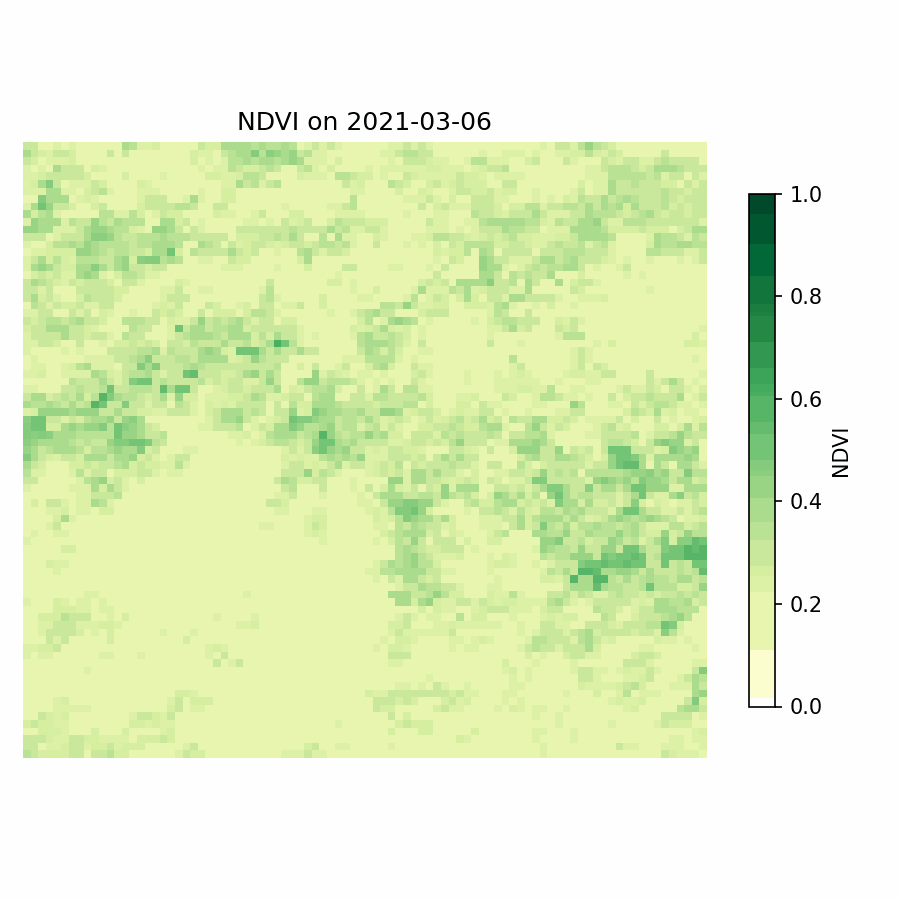

In [ ]:
from IPython.display import Image

Image(filename="ndvi_timelapse_mar_to_sep.gif")